# <a href="https://mipt-stats.gitlab.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 7. Решающие деревья и случайные леса.


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds22_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 15 баллов
* Задача 2 &mdash; 50 баллов
* Задача 3 &mdash; 30 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.6, palette='autumn')

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

При решении задания используйте `sklearn`. Пропишите сюда необходимые импорты

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
import graphviz

Перед выполнением задания обязательно посмотрите <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/trees.html">ноутбук</a> с занятия по решающим деревьям.

---
### Задача 1.

Перед обучением линейной регрессии вы могли совершать некоторые преобразования над признаками. Какие преобразования стоит совершить перед обучением решающего дерева?

В частности, ответьте на вопрос, имеет ли смысл примененять следующие преобразования:
* монотонные функции от одного признака;
* немонотонные функции от одного признака;
* линейные функции от нескольких признаков;
* нелинейные функции от нескольких признаков;
* стандартизация признаков;
* преобразования категориальных признаков.

---
### Задача 2.

Рассмотрим данные из <a href="https://mipt-stats.gitlab.io/courses/ad_fivt/task6.html" target="_blank">предыдущего домашнего задания</a>. Скачайте данные и разделите их на три части &mdash; обучающую, валидационную и тестовую в соотношении 3:1:1.

In [245]:
bike_sharing_df = pd.read_csv('day.csv')
train, test = train_test_split(bike_sharing_df, test_size=0.4)
valid, test = train_test_split(test, test_size=0.5)
train.shape, valid.shape, test.shape

((438, 16), (146, 16), (147, 16))

Выполните необходимые преобразования признаков

In [246]:
features = ['temp', 'hum', 'windspeed', 'workingday', 'weathersit', 'weekday', 'mnth']
target_feature = 'cnt'
train = train[train['hum'] > 0.25]
train = train[train['windspeed'] < 0.5]

Обучите решающее дерево глубины 3 и визуализируйте его

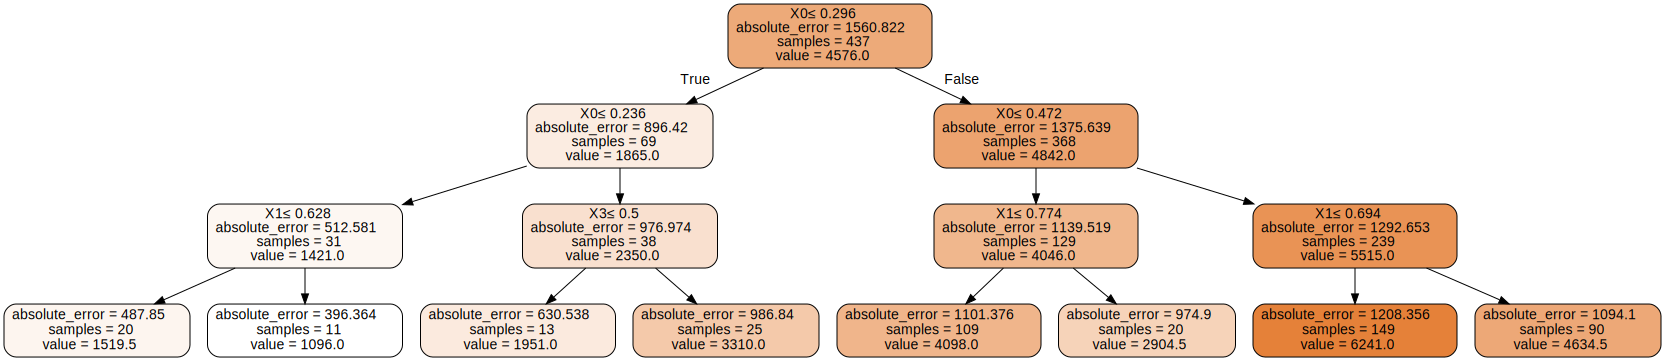

In [247]:
tree = DecisionTreeRegressor(max_depth=3, criterion='absolute_error')
tree = tree.fit(train[features], train[target_feature])
predictions = tree.predict(train[features])
mean_squared_error(predictions, train[target_feature])
dot_data = export_graphviz(
        tree, out_file=None,  
        filled=True, rounded=True, special_characters=True
)  
graphviz.Source(dot_data)

Подберите оптимальное значение максимальной глубины дерева. Для этого обучите решающие деревья с выставленным значением соответствующего гиперпараметра и посчитайте точность предсказаний каждого из них на валидационной выборке. Постройте соответствующий график.

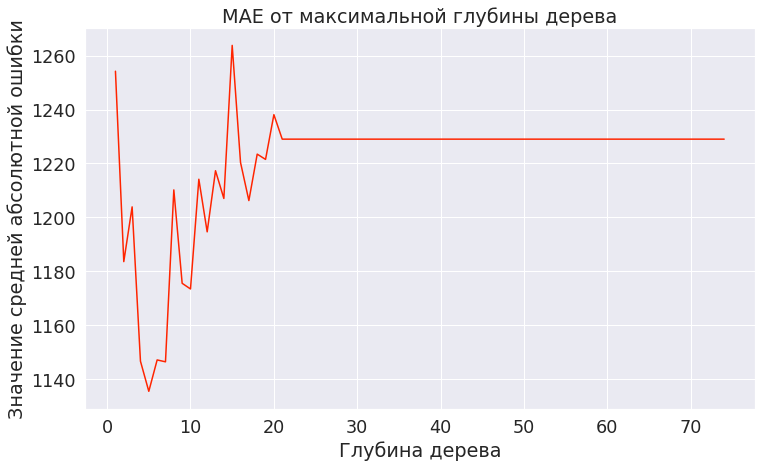

In [248]:
res = {}
for i in range(1, 75):
    tree = DecisionTreeRegressor(random_state= 42, max_depth=i, criterion='absolute_error')
    tree = tree.fit(train[features], train[target_feature])
    predictions = tree.predict(valid[features])
    res[i] = mean_absolute_error(predictions, valid[target_feature])
plt.figure(figsize=(12,7))
plt.title('MAE от максимальной глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('Значение средней абсолютной ошибки')
sns.lineplot(y=res.values(), x=res.keys())
plt.show()

In [249]:
max_depth = list(res.values()).index(min(res.values())) + 1
print('Оптимальная максимальная глубина:', max_depth)

Оптимальная максимальная глубина: 5


Аналогичным образом подберите минимальное число объектов в листе, зафиксировав при этом подобранное значение максимальной глубины.

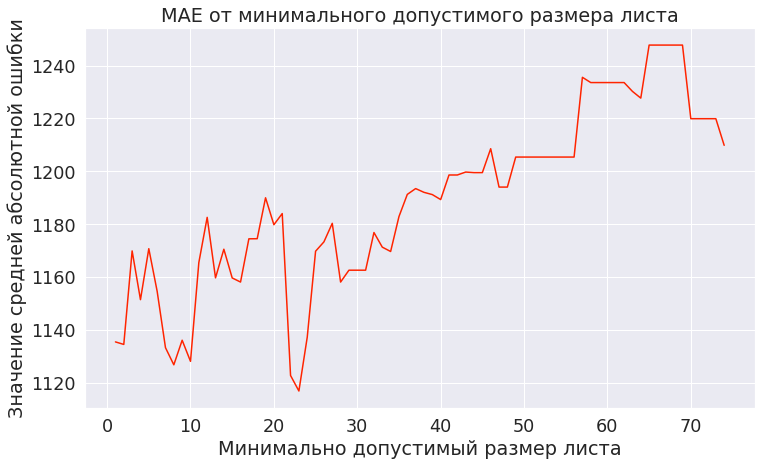

In [250]:
res={}
for i in range(1, 75):
    tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf = i,\
                                 criterion='absolute_error', random_state=42)
    tree = tree.fit(train[features], train[target_feature])
    predictions = tree.predict(valid[features])
    res[i] = mean_absolute_error(predictions, valid[target_feature])
plt.figure(figsize=(12,7))
plt.title('MAE от минимального допустимого размера листа')
plt.xlabel('Минимально допустимый размер листа')
plt.ylabel('Значение средней абсолютной ошибки')
sns.lineplot(y=res.values(), x=res.keys())
plt.show()

In [251]:
min_leaf = list(res.values()).index(min(res.values())) + 1
print('Оптимальное минимальное число вершин:', min_leaf)

Оптимальное минимальное число вершин: 23


Визуализируйте дерево при оптимальных гиперпараметрах и посчитайте его точность на тестовой части выборки.

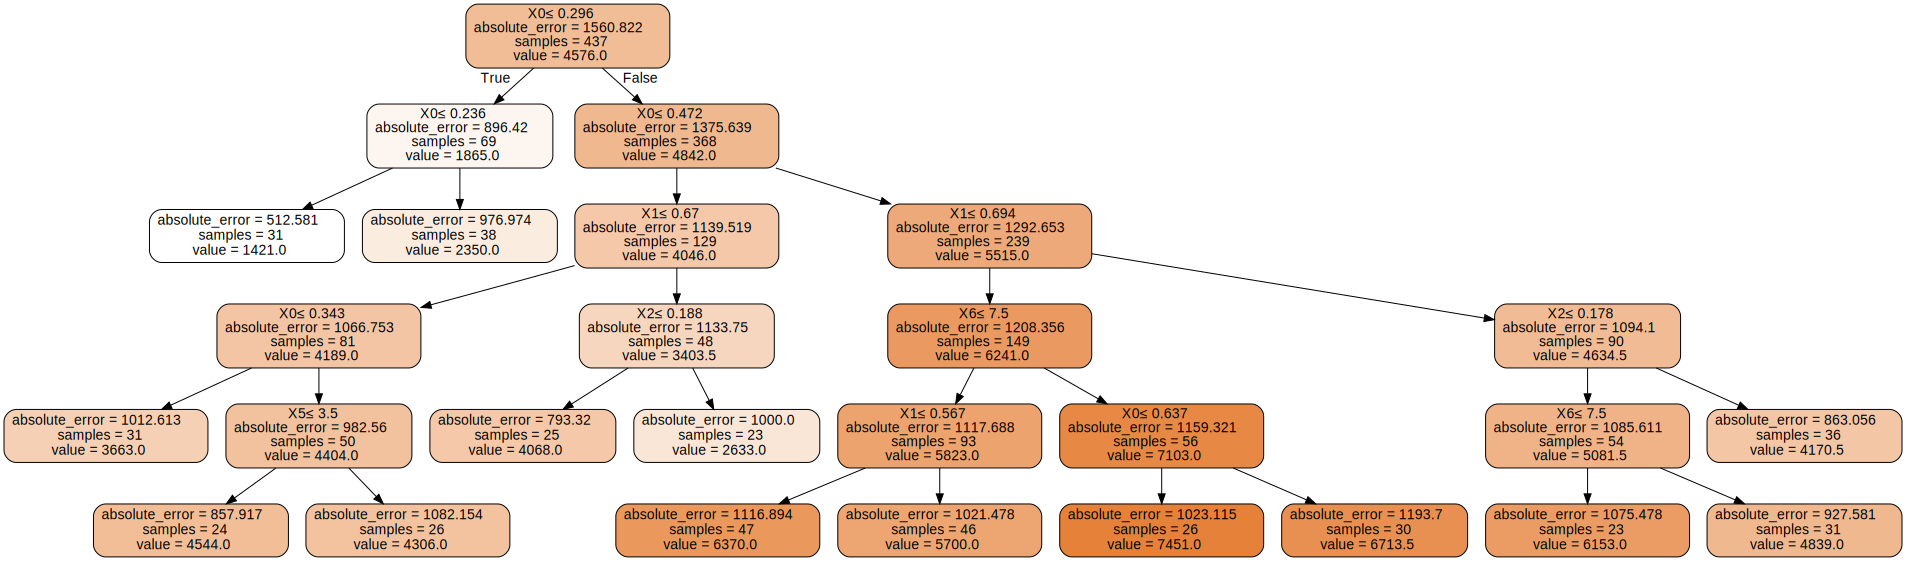

In [253]:
tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf = min_leaf, criterion='absolute_error')
tree = tree.fit(train[features], train[target_feature])
dot_data = export_graphviz(
        tree, out_file=None,  
        filled=True, rounded=True, special_characters=True
)
graphviz.Source(dot_data)

In [254]:
predictions = tree.predict(test[features])
mean_absolute_error(predictions, test[target_feature])

1137.3877551020407

Решающее дерево позволяет оценить *важность признаков* &mdash; некоторая величина, зависящая от того
* насколько часто тот или иной признак использовался при разбиении листа, 
* и насколько сильно при этом изменился критерий информативности.

У обученной модели значения важности признаков лежат в поле `feature_importances_`. Визуализируйте их с помощью `seaborn.barplot`.

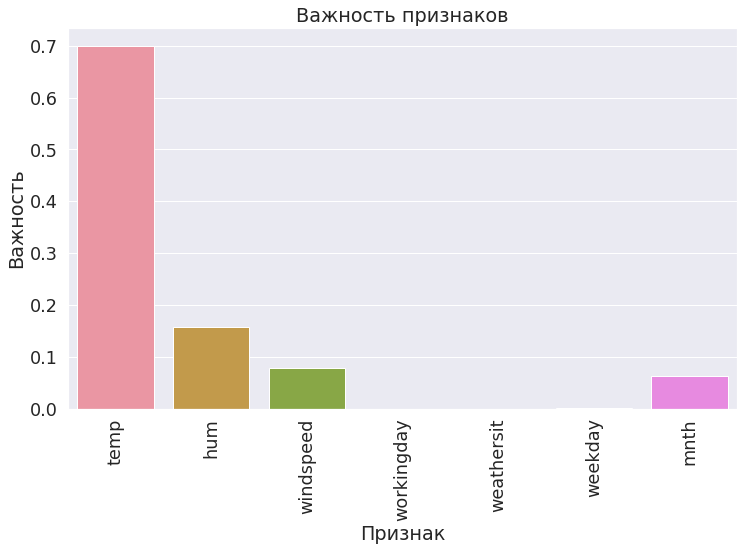

In [255]:
plt.figure(figsize=(12,7))
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Важность')
sns.barplot(y=tree.feature_importances_, x=features)
plt.xticks(rotation = 90)
plt.show()

Сделайте выводы.\
Наилучшая максимальная глубина решающего дерева - 5, что дает нам не более 32 различных значений. На больших значениях глубины происходит переобучение дерева, когда выбросы/погрешности обучающей выборки начинают восприниматься деревом. Из семи признаков, только температура, влажность, скорость ветра и месяц оказали какое-то влияние на решающее дерево, причем самым "важным" является температура. Исходя из данных, полученных в прошлой задаче, можно было предположить, что признак месяц будет более существенным параметром, количество велосипедов сильно варьировалось от месяца. Однако, на графике видно, что месяц не оказывает большого действия, возможно, из-за того, что его влияние учтено в признаке температура.\
График минимального допустимого количества листов от MAE возрастает, однако, при малых значениях кол-ва листов, наблюдается большая волатильность, это связано с тем, что появляются "очень маленькие листья", на которых ошибка очень мала, однако они порождают "большие" листья (глубина у нас была фиксирована, а значит и количество листов), которые содержат большое количество данных, которые, возможно, стоило разнести в разные листья.

---
### Задача 3.

Для данных из предыдущей части обучите случайный лес на 500 деревьев.

In [256]:
n_estimators = 500
model = RandomForestRegressor(n_estimators=n_estimators)
model.fit(train[features], train[target_feature])

RandomForestRegressor(n_estimators=500)

Постройте график зависимости точности модели в зависимости от количества деревьев для обучающей и валидационной выборок.

*Замечание.* Не нужно заново обучать лес каждый раз. Используйте у обученной модели поле `estimators_`, это список из объектов класса `DecisionTreeRegressor`.

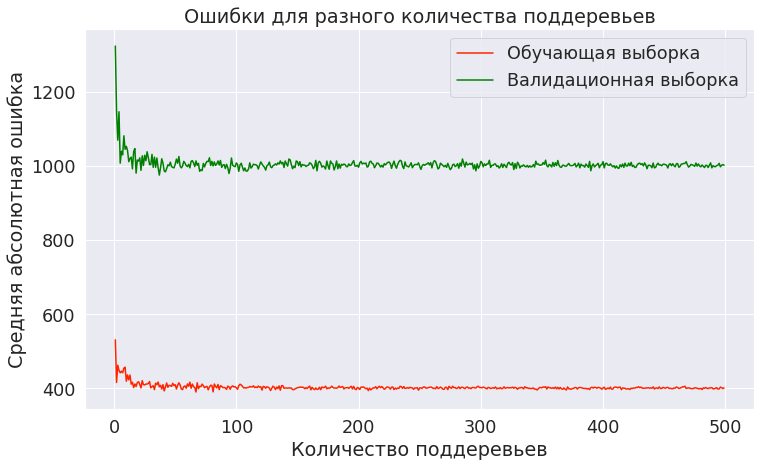

In [260]:
res = {}
for i in range(1, n_estimators):
    subforest = RandomForestRegressor(n_estimators=0)
    subforest.estimators_ = model.estimators_[0:i]
    subforest.n_estimators = i
    subforest.fit(train[features], train[target_feature])
    res[i] = mean_absolute_error(subforest.predict(train[features]), train[target_feature])

res2 = {}
for i in range(1, n_estimators):
    subforest = RandomForestRegressor(n_estimators=0)
    subforest.estimators_ = model.estimators_[0:i]
    subforest.n_estimators = i
    subforest.fit(train[features], train[target_feature])
    res2[i] = mean_absolute_error(subforest.predict(valid[features]), valid[target_feature])

    
plt.figure(figsize=(12,7))
plt.title('Ошибки для разного количества поддеревьев')
plt.xlabel('Количество поддеревьев')
plt.ylabel('Средняя абсолютная ошибка')
sns.lineplot(y=res.values(), x=res.keys(), label="Обучающая выборка")
sns.lineplot(y=res2.values(), x=res2.keys(), color="green", label="Валидационная выборка")
plt.show()

Для леса с максимальным количеством деревьев визуализируйте
важность признаков, используя поле `feature_importances_`. 

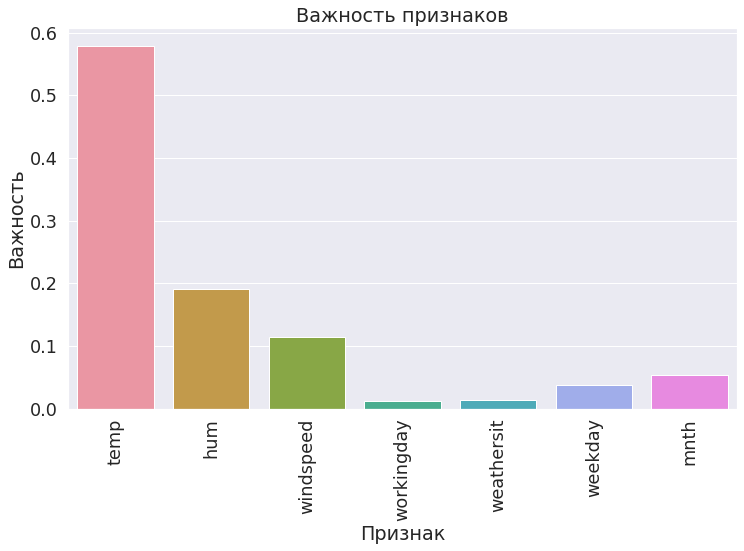

In [261]:
plt.figure(figsize=(12,7))
plt.title('Важность признаков')
plt.xlabel('Признак')
plt.ylabel('Важность')
sns.barplot(y=model.feature_importances_, x=features)
plt.xticks(rotation = 90)
plt.show()

Сделайте выводы.\
Показния леса стабилизируются уже на количестве деревьев~100, причем графики валидационной и обучающей выбор имеют одинаковый характер и скорость сходимсти. При этом, ошибка на валидационной выборке больше, но бОльшая ошибка не влияет сходимость графика. График важности признаков существенно не отличается от графиков из предыдущего пункта.\
Использование леса позволило уменьшить MAE примерно на 100.